In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [25, 50, 100]
roc_periods = [2, 5, 10]
multiplier = 50
bankroll = 15000
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20190101':]
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2019-01-02 00:00:00,2508.00,2509.50,2506.25,2509.00,1363,2507.875,423
2019-01-02 00:01:00,2509.00,2512.50,2508.75,2512.00,899,2510.725,301
2019-01-02 00:02:00,2512.25,2517.50,2511.50,2516.00,1108,2514.725,486
2019-01-02 00:03:00,2516.25,2516.75,2515.00,2515.00,493,2516.000,213
2019-01-02 00:04:00,2515.00,2515.75,2515.00,2515.00,184,2515.425,82
...,...,...,...,...,...,...,...
2019-09-05 08:51:00,2957.50,2957.75,2957.50,2957.50,361,2957.525,70
2019-09-05 08:52:00,2957.50,2958.00,2957.00,2957.25,517,2957.575,112
2019-09-05 08:53:00,2957.50,2957.75,2957.25,2957.50,267,2957.400,85


In [5]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols.tail()

,close,returns,vol_returns,vol_price,vol_price_alt
date,,,,,
2019-09-05 08:51:00,2957.50,0.000000,0.000197,0.581942,5.901660
2019-09-05 08:52:00,2957.25,-0.000085,0.000196,0.579301,5.904358
2019-09-05 08:53:00,2957.50,0.000085,0.000195,0.577293,5.903882
2019-09-05 08:54:00,2958.25,0.000254,0.000196,0.580163,5.895993
2019-09-05 08:55:00,2958.00,-0.000085,0.000195,0.577563,5.889905


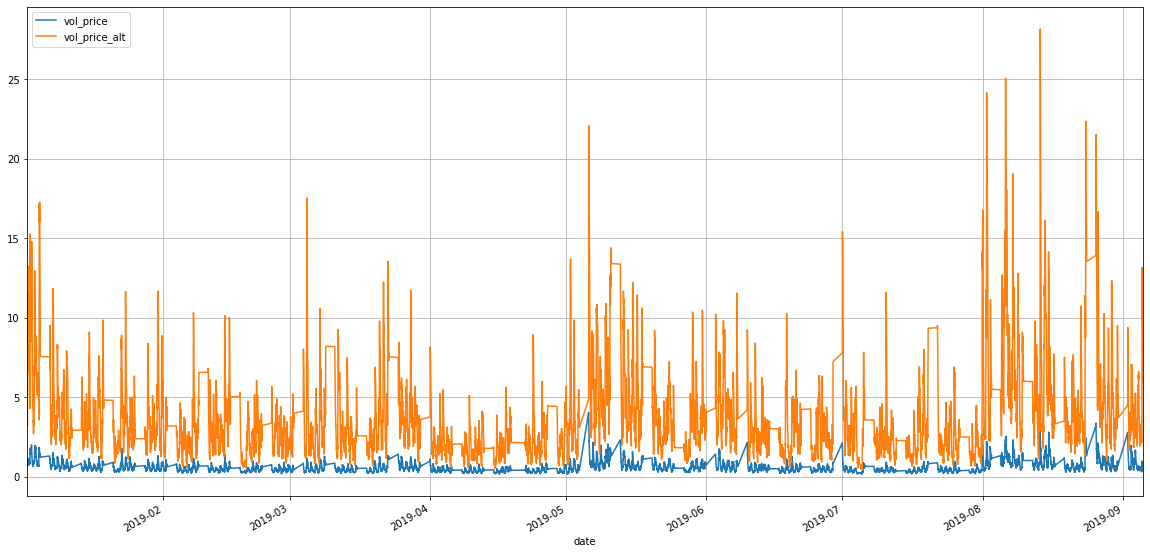

In [6]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [7]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

31026.176951223097

In [8]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2019-01-02 02:54:00,2508.00,2521.25,2506.25,2510.75,11596,30222,15.000000
1,2019-01-02 04:29:00,2510.75,2510.75,2488.00,2493.00,15182,33140,18.923438
2,2019-01-02 08:00:00,2492.75,2494.75,2477.00,2483.00,15075,30949,18.522473
3,2019-01-02 09:18:00,2483.00,2484.25,2464.25,2465.50,11917,30163,18.905820
4,2019-01-02 09:52:00,2465.25,2465.75,2452.25,2456.50,12616,31927,17.769931
...,...,...,...,...,...,...,...,...
7330,2019-09-05 03:38:00,2943.75,2962.50,2943.50,2961.75,9488,36394,5.314277
7331,2019-09-05 04:04:00,2961.50,2968.50,2958.50,2968.00,7621,31889,5.429974
7332,2019-09-05 05:05:00,2968.00,2971.75,2965.50,2967.75,7450,31492,5.450221


In [9]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [10]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [11]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [12]:
def breakout(data, periods, smooth, *args):
    """
    this doesn't belong here
    """
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / data['breakout'].rolling(periods).std()
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [13]:
def diff(data, periods, smooth, vol):
    data = data.copy()
    data['diff'] = data.close.diff(periods)
    data[f'diff_{periods}'] = data['diff'].ewm(span=smooth).mean()
    return data[f'diff_{periods}']

In [14]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [15]:
vols = vol(data, vol_lookback)

In [16]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [17]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema])
forecasts['diff'] = pd.DataFrame([diff(data, p, smooth, vol) for p in roc_periods]).T.mean(axis=1)

In [18]:
forecasts.tail()

,carver,ema,diff
label,,,
7330,0.399410,2.203225,5.428920
7331,0.407148,2.263064,7.286951
7332,0.413966,2.335228,8.463596
7333,0.417666,2.416202,9.197166
7334,0.410859,2.495768,9.124307


In [19]:
data = data.join(forecasts)
data = data.iloc[200:]

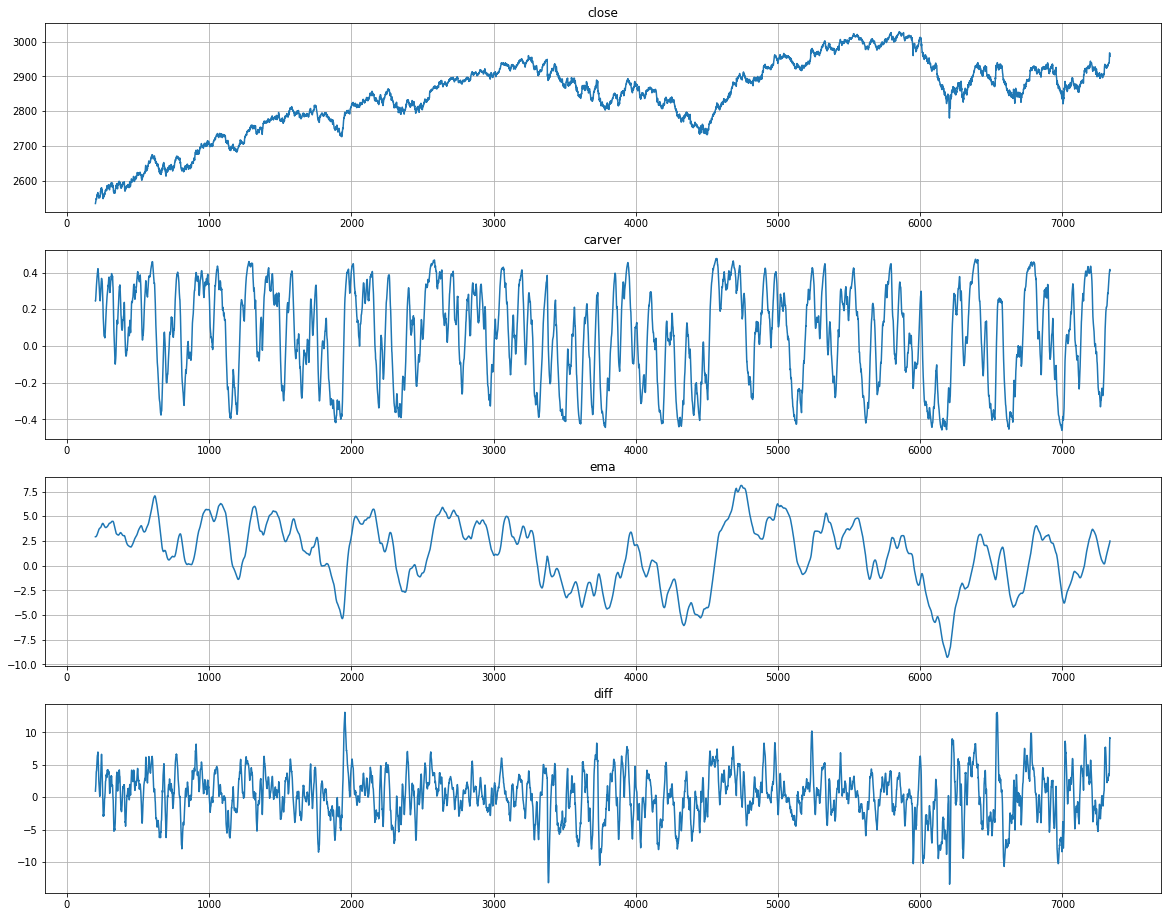

In [20]:
plot(data[['close', 'carver', 'ema', 'diff']])

In [21]:
10 / data[['carver', 'ema', 'diff']].abs().mean()

carver    43.911460
ema        3.399112
diff       3.490927
dtype: float64

In [22]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 43).clip(lower=-20, upper=20),
                       #'breakout': (data.breakout * 8.7).clip(lower=-20, upper=20),
                       'ema': (data.ema * 3.6).clip(lower=-20, upper=20),
                       'diff': (data['diff'] * 3).clip(lower=-20, upper=20)}
                     )

In [23]:
scaled['combined'] = scaled[['carver', 'ema', 'diff']].mean(axis=1)

In [24]:
scaled['combined'].std()

8.743929351734744

In [25]:
10 / scaled['combined'].std()

1.143650594342469

In [26]:
scaled['combined'] = scaled['combined'] 

In [27]:
scaled[['carver', 'ema', 'diff']].corr()

,carver,ema,diff
carver,1.000000,0.541117,0.761762
ema,0.541117,1.000000,0.195986
diff,0.761762,0.195986,1.000000


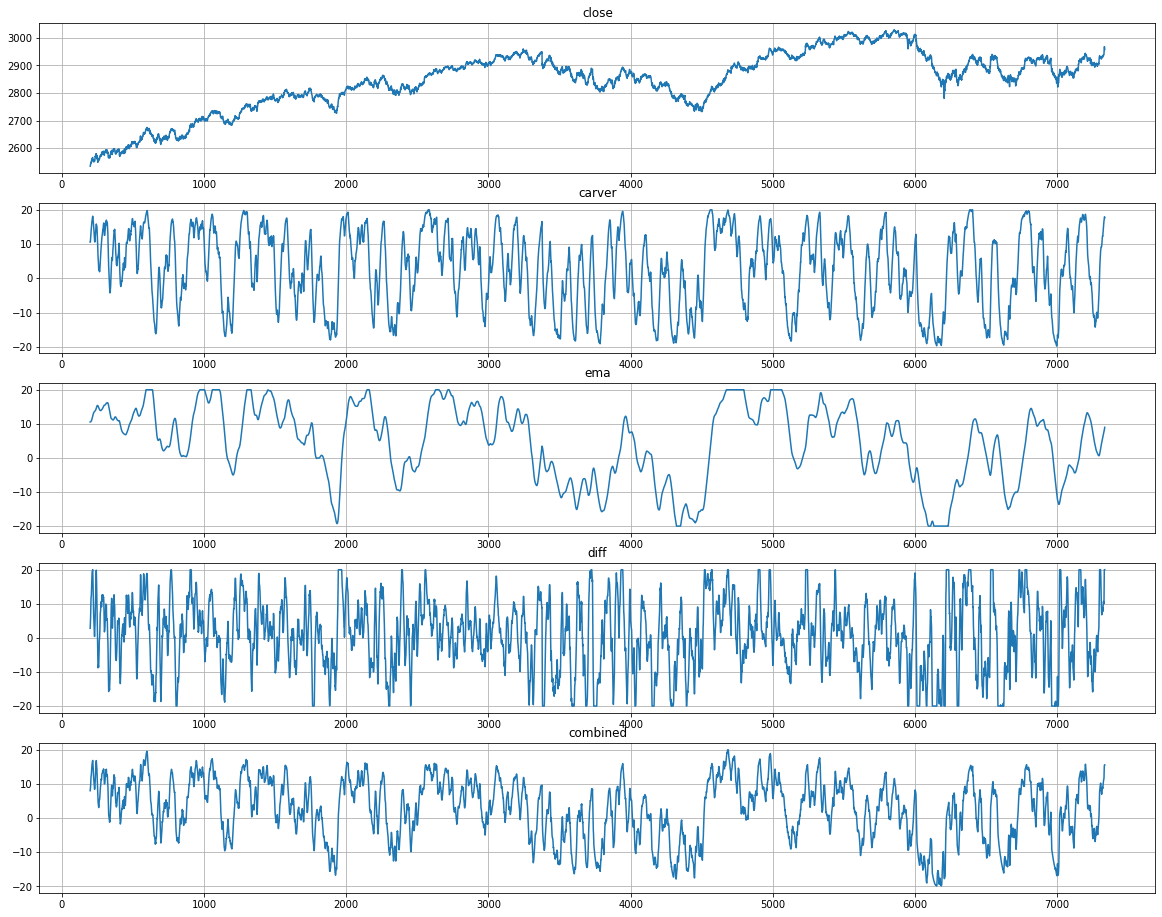

In [28]:
plot(scaled[['close', 'carver', 'ema', 'diff', 'combined']])

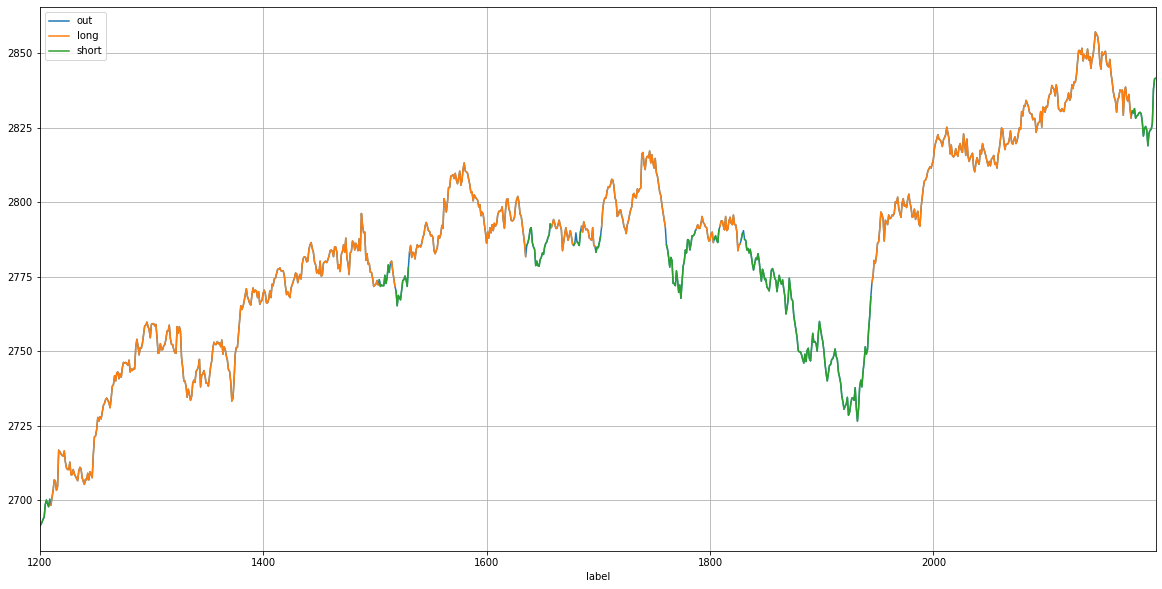

In [29]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close.iloc[1000:2000], scaled['combined'].iloc[1000:2000], 0)

In [30]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 1, 2, 3, 4, 5, 6, 7, 10, 15]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [31]:
stats

,0,1,2,3,4,5,6,7,10,15
Annual return,0.133256,0.116469,0.121174,0.106493,0.113973,0.143454,0.0496616,0.0278173,0.131338,-0.112599
Cumulative returns,0.0907566,0.0795107,0.0826675,0.0728026,0.0778337,0.0975634,0.034231,0.0192365,0.0894742,-0.0796094
Annual volatility,0.124782,0.124321,0.120824,0.119516,0.112778,0.101502,0.105201,0.10015,0.0695709,0.0444522
Sharpe ratio,1.06475,0.948163,1.00685,0.906228,1.01317,1.37132,0.512877,0.323625,1.80865,-2.6646
Calmar ratio,1.60524,1.65798,1.84943,1.90367,1.99577,2.45885,0.735537,0.410522,5.6763,-1.41439
Stability,0.302623,0.428354,0.324857,0.465076,0.490105,0.633831,0.0895557,0.0438808,0.677118,0.949233
Max drawdown,-0.0830133,-0.0702479,-0.0655195,-0.0559407,-0.057107,-0.058342,-0.0675174,-0.0677608,-0.023138,-0.0796094
Omega ratio,1.1978,1.17545,1.1863,1.16553,1.19276,1.28195,1.10173,1.06434,1.4661,0.314804
Sortino ratio,1.58343,1.39244,1.51552,1.35712,1.59152,2.30585,0.815714,0.508119,3.28194,-3.35529
Skew,0.0395643,-0.00214052,0.173296,0.171113,0.445529,0.773086,0.792867,0.693243,1.0297,0.297937


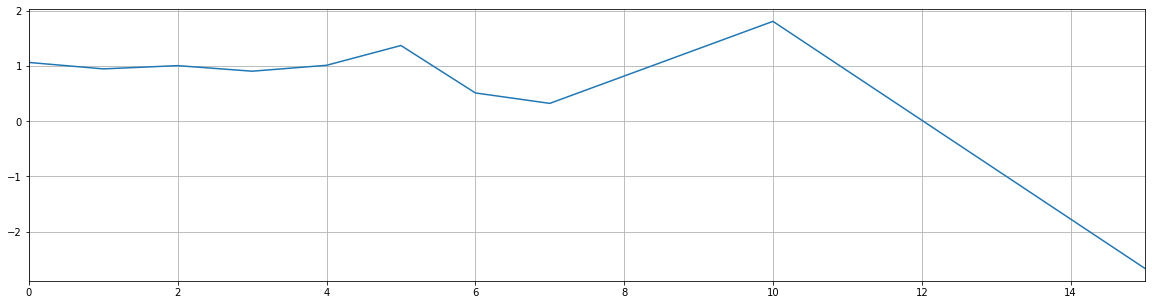

In [32]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [33]:
returns.corr()

,0,1,2,3,4,5,6,7,10,15
0,1.000000,0.951200,0.922647,0.893571,0.828618,0.790427,0.767550,0.688901,0.557915,0.247346
1,0.951200,1.000000,0.950803,0.923034,0.845184,0.808053,0.780321,0.707357,0.575528,0.280591
2,0.922647,0.950803,1.000000,0.969651,0.905862,0.872061,0.837932,0.785611,0.624302,0.248006
3,0.893571,0.923034,0.969651,1.000000,0.936476,0.893978,0.851702,0.799468,0.634331,0.274010
4,0.828618,0.845184,0.905862,0.936476,1.000000,0.963927,0.924079,0.881838,0.708319,0.249578
5,0.790427,0.808053,0.872061,0.893978,0.963927,1.000000,0.963269,0.922751,0.747814,0.261965
6,0.767550,0.780321,0.837932,0.851702,0.924079,0.963269,1.000000,0.944665,0.770545,0.271715
7,0.688901,0.707357,0.785611,0.799468,0.881838,0.922751,0.944665,1.000000,0.790979,0.266071
10,0.557915,0.575528,0.624302,0.634331,0.708319,0.747814,0.770545,0.790979,1.000000,0.264241
15,0.247346,0.280591,0.248006,0.274010,0.249578,0.261965,0.271715,0.266071,0.264241,1.000000


In [34]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 10, 15]:
    b = v_backtester(scaled_reindexed.open, scaled_reindexed.combined, i)
    r = perf(b, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [35]:
stats

,0,5,10,15
Annual return,1.26936,1.37647,1.24934,-0.799597
Cumulative returns,0.766667,0.824167,0.755833,-0.6725
Annual volatility,0.776165,0.671285,0.461244,0.6054
Sharpe ratio,1.44452,1.62028,1.98472,-2.34949
Calmar ratio,2.79734,3.752,7.85745,-1.18899
Stability,0.261483,0.610024,0.674148,0.913427
Max drawdown,-0.453773,-0.366864,-0.159001,-0.6725
Omega ratio,1.27604,1.33328,1.5069,0.352105
Sortino ratio,2.1873,2.74962,3.67522,-3.16372
Skew,-0.0817684,0.578885,1.06067,1.77505
